In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cdflib 
from cdflib import cdfepoch
from pathlib import Path
import pickle
from datetime import date

In [4]:
#ACCファイルの変数名を確認
cdf = cdflib.CDF("data/swarm/2020_ACC/SW_OPER_DNSCACC_2__20200216T000000_20200216T235950_0201.cdf")

info = cdf.cdf_info()
print("rVariables:", info.rVariables)
print("zVariables:", info.zVariables)

rVariables: []
zVariables: ['time', 'density', 'altitude', 'latitude', 'longitude', 'local_solar_time']


In [ ]:
#ACCファイルの変数名を確認
cdf = cdflib.CDF("data/swarm/2020_ACC/SW_OPER_DNSCACC_2__20200216T000000_20200216T235950_0201.cdf")
info = cdf.cdf_info()
print(info)


CDFInfo(CDF=PosixPath('/workspace/data/swarm/2020_ACC/SW_OPER_DNSCACC_2__20200216T000000_20200216T235950_0201.cdf'), Version='3.6.3', Encoding=6, Majority='Row_major', rVariables=[], zVariables=['time', 'density', 'altitude', 'latitude', 'longitude', 'local_solar_time'], Attributes=[{'TITLE': 'Global'}, {'ORIGINAL_PRODUCT_NAME': 'Global'}, {'CREATOR': 'Global'}, {'TIME SYSTEM': 'Global'}, {'VARIABLE DESCRIPTION': 'Variable'}, {'UNITS': 'Variable'}, {'FORMAT': 'Variable'}, {'FILLVAL': 'Variable'}, {'SATELLITE': 'Global'}, {'DESCRIPTION': 'Global'}, {'DAILY_QUALITY_INDEX': 'Global'}], Copyright='\nCommon Data Format (CDF)\n(C) Copyright 1990-2016 NASA/GSFC\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n(Internet -- GSFC-CDF-SUPPORT@LISTS.NASA.GOV)\n', Checksum=False, Num_rdim=0, rDim_sizes=[], Compressed=False, LeapSecondUpdate=None)


In [5]:
#PODファイルの変数名を確認
cdf = cdflib.CDF("data/swarm/2020_POD/SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf")
info = cdf.cdf_info()
print("rVariables:", info.rVariables)
print("zVariables:", info.zVariables)

rVariables: []
zVariables: ['time', 'density', 'density_orbitmean', 'validity_flag', 'altitude', 'latitude', 'longitude', 'local_solar_time']


In [ ]:
#pandasDataFrameにすることによって時系列データを扱える
#cdf→DataFrameをするための関数を定義
def read_cdf_to_df(path: Path, time_var="time", var_map=None) -> pd.DataFrame:
    """
    CDFを読み、index=time（UTC）、列に var_map で指定した変数を入れた DataFrame を返す。
    var_map: {出力列名: CDF変数名}
    """
    #cdfファイル読み取り
    c = cdflib.CDF(str(path))
    #時刻配列を Datetime に変換し、DataFrameIndex にする
    t = pd.to_datetime(cdfepoch.to_datetime(c.varget(time_var)))  # UTC naive
    df = pd.DataFrame(index=pd.DatetimeIndex(t, name="time"))
    
    if var_map:
        for out, var in var_map.items():
            arr = np.asarray(c.varget(var))
            if arr.ndim == 1 and len(arr) == len(df):
                # --- ここから: FILLVAL を NaN に ---
                try:
                    atts = c.varattsget(var)
                    fill = atts.get("FILLVAL", None)
                    if isinstance(fill, str):
                        # "0.99900E+33" のような文字列も欠損値とする
                        fill = float(fill.replace("D", "E"))
                    if fill is not None:
                        arr = np.where(arr == fill, np.nan, arr)
                    # 念のため、1e30 以上は欠損扱いとした
                    arr = np.where(arr > 1e30, np.nan, arr)
                except Exception:
                    pass
                # --- ここまで ---
                df[out] = arr
    return df.sort_index()

def bin_one_day(df: pd.DataFrame, date: str, secs: int, cols: list) -> pd.DataFrame:
    """
    指定日のデータを 'secs' 秒間隔の等間隔グリッドに詰め直す。
    例) POD: secs=30 -> 2880点, ACC: secs=10 -> 8640点
    cols: グリッド化対象の列名（例: ['density','altitude', ...]）
    """
    day = pd.to_datetime(date).date()
    d = df.loc[df.index.date == day].copy()
    if d.empty:
        # 空でも正しい長さのNaNで返す
        start = pd.Timestamp(str(day))
        idx = pd.date_range(start, start + pd.Timedelta(days=1) - pd.Timedelta(seconds=secs), freq=f"{secs}S")
        out = pd.DataFrame(index=idx, columns=cols, dtype=float)
        return out

    # その日の秒（00:00:00 からの経過秒）
    sec_of_day = (d.index - pd.Timestamp(str(day))).total_seconds()
    # どのバケット（0..n_bins-1）に入るか
    bin_idx = np.floor_divide(sec_of_day + secs/2, secs).astype(int)  # 最近傍に丸め
    n_bins = int(24*3600 // secs)

    # グリッドの時間軸
    start = pd.Timestamp(str(day))
    grid_index = pd.date_range(start, start + pd.Timedelta(days=1) - pd.Timedelta(seconds=secs), freq=f"{secs}s")

    # 初期化（NaNで満たす）
    out = pd.DataFrame(index=grid_index, columns=cols, dtype=float)

    # 同じバケットに複数サンプルが来た場合は平均（お好みで最新値などに変更可）
    for c in cols:
        tmp = pd.DataFrame({"bin": bin_idx, c: d[c].to_numpy(dtype=float)})
        grouped = tmp.groupby("bin")[c].mean()  # 代表値の定義：平均
        valid_bins = grouped.index[(grouped.index >= 0) & (grouped.index < n_bins)]
        out.loc[out.index[valid_bins], c] = grouped.loc[valid_bins].values

    return out

In [25]:

# === 設定 ===
CHOICE = "POD"   # "POD" か "ACC"
YEAR   = 2020    # 先生コードと同じ条件
ROOT   = Path("data")  # あなたの data/ のルート

# === ファイル探索 ===
if CHOICE.upper() == "POD":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "POD" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
        "validity_flag": "validity_flag",
        "density_orbitmean": "density_orbitmean",
    }
    bin_secs = 30      # 30秒 -> 2880点
elif CHOICE.upper() == "ACC":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "ACC" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
    }
    bin_secs = 10      # 10秒 -> 8640点
else:
    raise ValueError("CHOICE must be 'POD' or 'ACC'")

print(f"Found {len(files)} {CHOICE} files in {YEAR}")

# === 読み込み & 日単位グリッド化 → DNS 辞書に格納 ===
DNS = {}  # {doy: DataFrame(columns=cols + meta)}

for f in files:
    # ファイル→DF
    df = read_cdf_to_df(f, time_var="time", var_map=var_map)

    # POD: validity_flagがあればフィルタ（1を有効と想定）
    CHOICE = "POD"
    YEAR = 2020

    # ファイル内に含まれるユニークな日を順に処理
    for date in sorted({ts.date() for ts in df.index}):
        date_str = str(date)
        # 欲しい列（DNSに入れたいコア項目）
        cols = [c for c in ["density","altitude","latitude","longitude","local_solar_time"] if c in df.columns]
        binned = bin_one_day(df, date_str, secs=bin_secs, cols=cols)

        # doy を MATLAB と同様に 1始まりで計算
        doy = (pd.Timestamp(date_str) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

        # T（先生コードの day-of-year 小数日）相当を入れるなら：
        # 小数日 = (doy-1) + (経過秒 / 86400)
        seconds = (binned.index - pd.Timestamp(date_str)).total_seconds()
        T = (doy - 1) + seconds / 86400.0

        # ymd は [Y M D h m s] を入れたい場合
        ymd = np.column_stack([
            np.full(len(binned), int(date_str[:4])),
            np.full(len(binned), int(date_str[5:7])),
            np.full(len(binned), int(date_str[8:10])),
            binned.index.hour, binned.index.minute, binned.index.second
        ])

        # DNS[doy] を DataFrame で持つ（先生の構造体に相当）
        out = binned.copy()
        out["T"] = T
        # 必要なら ymd は別管理でもOK（ここでは別キーに入れる）
        DNS[doy] = {"data": out, "ymd": ymd, "date": date_str}

print(f"Days collected: {len(DNS)}")

# === 保存（お好みで選択） ===
# 1) Python 標準（pickle）
import pickle
save_path = Path(f"DNS_{CHOICE}_{YEAR}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(DNS, f)
print("Saved:", save_path)

# 2) MATLAB .mat で保存したい場合（scipy 必要）
# from scipy.io import savemat
# # scipy の savemat は構造体に制限があるため、簡易に array として保存する例：
# mdict = {}
# for doy, v in DNS.items():
#     mdict[f"DNS_{doy}_data"] = v["data"].to_records(index=True)  # timeはindex
#     mdict[f"DNS_{doy}_ymd"]  = v["ymd"]
# savemat(f"DNS_{CHOICE}_{YEAR}.mat", mdict)


Found 121 POD files in 2020
Days collected: 121
Saved: DNS_POD_2020.pkl


In [26]:
# === 設定 ===
CHOICE = "ACC"   # "POD" か "ACC"
YEAR   = 2020    # 先生コードと同じ条件
ROOT   = Path("data")  # あなたの data/ のルート

# === ファイル探索 ===
if CHOICE.upper() == "POD":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "POD" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
        "validity_flag": "validity_flag",
        "density_orbitmean": "density_orbitmean",
    }
    bin_secs = 30      # 30秒 -> 2880点
elif CHOICE.upper() == "ACC":
    files = sorted(p for p in ROOT.rglob("*.cdf") if "ACC" in p.name.upper() and f"{YEAR}" in p.name)
    var_map = {
        "density": "density",
        "altitude": "altitude",
        "latitude": "latitude",
        "longitude": "longitude",
        "local_solar_time": "local_solar_time",
    }
    bin_secs = 10      # 10秒 -> 8640点
else:
    raise ValueError("CHOICE must be 'POD' or 'ACC'")

print(f"Found {len(files)} {CHOICE} files in {YEAR}")

# === 読み込み & 日単位グリッド化 → DNS 辞書に格納 ===
DNS = {}  # {doy: DataFrame(columns=cols + meta)}

for f in files:
    # ファイル→DF
    df = read_cdf_to_df(f, time_var="time", var_map=var_map)

    # POD: validity_flagがあればフィルタ（1を有効と想定）
    CHOICE = "POD"
    YEAR = 2020

    # ファイル内に含まれるユニークな日を順に処理
    for date in sorted({ts.date() for ts in df.index}):
        date_str = str(date)
        # 欲しい列（DNSに入れたいコア項目）
        cols = [c for c in ["density","altitude","latitude","longitude","local_solar_time"] if c in df.columns]
        binned = bin_one_day(df, date_str, secs=bin_secs, cols=cols)

        # doy を MATLAB と同様に 1始まりで計算
        doy = (pd.Timestamp(date_str) - pd.Timestamp(f"{YEAR}-01-01")).days + 1

        # T（先生コードの day-of-year 小数日）相当を入れるなら：
        # 小数日 = (doy-1) + (経過秒 / 86400)
        seconds = (binned.index - pd.Timestamp(date_str)).total_seconds()
        T = (doy - 1) + seconds / 86400.0

        # ymd は [Y M D h m s] を入れたい場合
        ymd = np.column_stack([
            np.full(len(binned), int(date_str[:4])),
            np.full(len(binned), int(date_str[5:7])),
            np.full(len(binned), int(date_str[8:10])),
            binned.index.hour, binned.index.minute, binned.index.second
        ])

        # DNS[doy] を DataFrame で持つ（先生の構造体に相当）
        out = binned.copy()
        out["T"] = T
        # 必要なら ymd は別管理でもOK（ここでは別キーに入れる）
        DNS[doy] = {"data": out, "ymd": ymd, "date": date_str}

print(f"Days collected: {len(DNS)}")

# === 保存（お好みで選択） ===
# 1) Python 標準（pickle）
import pickle
save_path = Path(f"DNS_ACC_{YEAR}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(DNS, f)
print("Saved:", save_path)

Found 75 ACC files in 2020
Days collected: 75
Saved: DNS_ACC_2020.pkl


In [ ]:
f = Path("data") / "swarm" / "2020_POD" / "SW_OPER_DNSCPOD_2__20200216T000000_20200216T235930_0201.cdf"
cdf = cdflib.CDF(str(f))

# density 変数の属性を表示
print(cdf.varattsget("density"))

print(cdf.varattsget("altitude"))

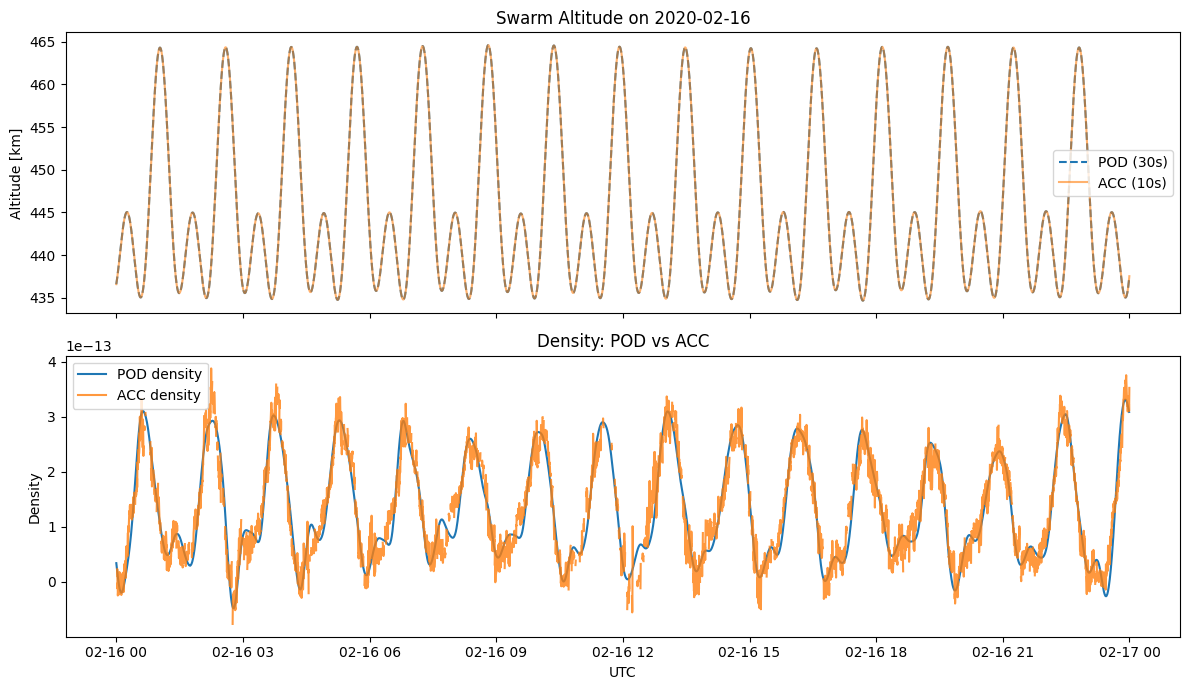

In [15]:
# 読み込み
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

# 日付→DOY（2020基準）
def doy(dt):
    return (dt - date(2020,1,1)).days + 1

the_day = date(2020,2,16)
k = doy(the_day)

P = DNS_POD[k]["data"]
A = DNS_ACC[k]["data"]

# --- Plot ---
fig, axes = plt.subplots(2,1,figsize=(12,7),sharex=True)

# 高度を km に変換してからプロット
axes[0].plot(P.index, P["altitude"]/1000, label="POD (30s)", linestyle="--")
axes[0].plot(A.index, A["altitude"]/1000, alpha=0.6, label="ACC (10s)", linestyle="-")
axes[0].set_ylabel("Altitude [km]")
axes[0].set_title(f"Swarm Altitude on {the_day}")
axes[0].legend()

# 密度
axes[1].plot(P.index, P["density"], label="POD density")
axes[1].plot(A.index, A["density"], alpha=0.8, label="ACC density")
axes[1].set_ylabel("Density")
axes[1].set_title("Density: POD vs ACC")
axes[1].legend()

plt.xlabel("UTC")
plt.tight_layout()
plt.show()

In [24]:
# 2020年のDNS（POD/ACC）を読み込み
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

def doy_2020(d: date) -> int:
    """2020-01-01 を 1 とする DOY（1始まり）"""
    return (d - date(2020,1,1)).days + 1

def concat_dns_month(DNS: dict, year: int, month: int) -> pd.DataFrame:
    """DNS（DOY→DataFrame）から、指定の年月だけを縦結合して返す"""
    frames = []
    for k in sorted(DNS.keys()):
        df = DNS[k]["data"]
        if not df.empty:
            dfm = df.loc[f"{year:04d}-{month:02d}-01":f"{year:04d}-{month:02d}-31 23:59:59"]
            if not dfm.empty:
                frames.append(dfm)
    return pd.concat(frames).sort_index() if frames else pd.DataFrame()


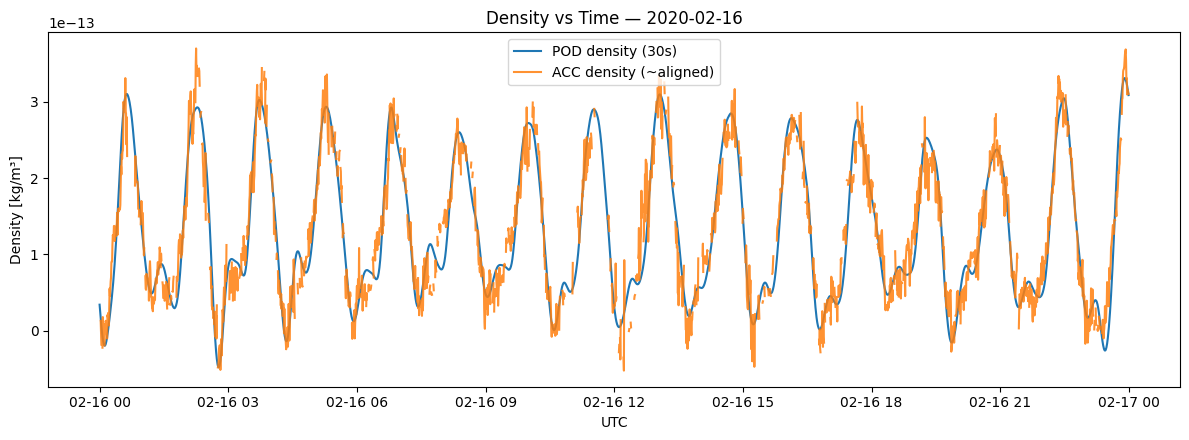

In [25]:
# === 解析したい日付 ===
the_day = date(2020, 2, 16)  # ← 好きな日に変更

k = doy_2020(the_day)
P = DNS_POD.get(k, {}).get("data")
A = DNS_ACC.get(k, {}).get("data")

if P is None or A is None:
    raise ValueError(f"DNS に {the_day} の日が見つかりません（POD/ACCのどちらか欠け）")

# POD基準でACC密度を合わせる（±30s）
merged = pd.merge_asof(
    P.sort_index()[["density"]].rename(columns={"density":"rho_pod"}),
    A.sort_index()[["density"]].rename(columns={"density":"rho_acc"}),
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)

fig, ax = plt.subplots(figsize=(12,4.5))
ax.plot(merged.index, merged["rho_pod"], label="POD density (30s)")
ax.plot(merged.index, merged["rho_acc"], label="ACC density (~aligned)", alpha=0.85)
ax.set_title(f"Density vs Time — {the_day.isoformat()}")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend()
plt.tight_layout(); plt.show()


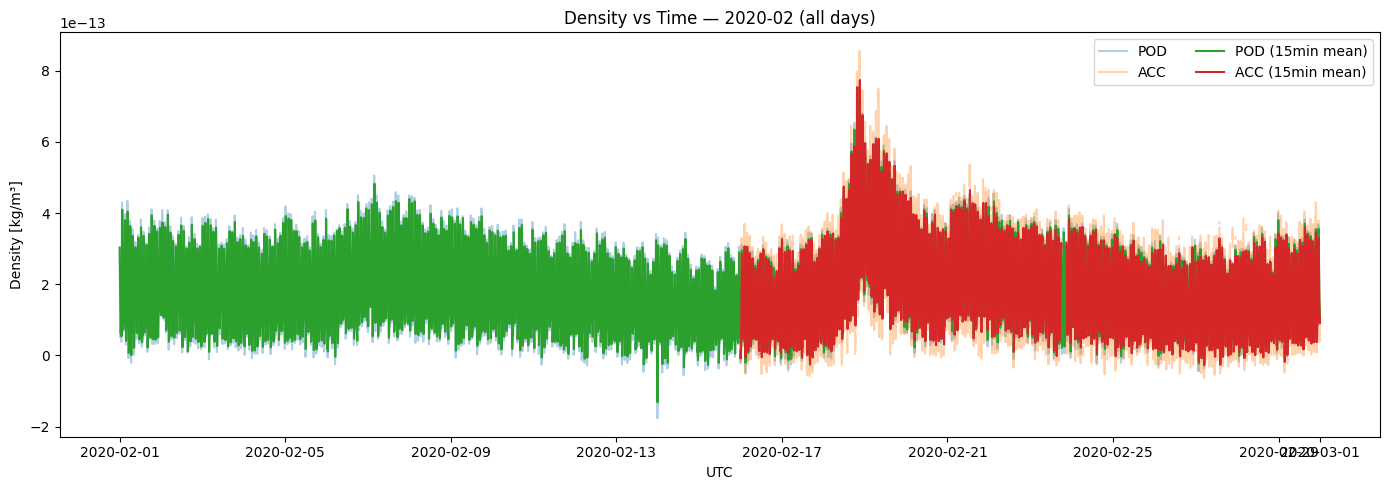

In [27]:
# === 解析したい月 ===
YEAR, MONTH = 2020, 2   # ← 好きな年・月に変更（1〜4月が手元データ）

def concat_dns_month(DNS: dict, year: int, month: int) -> pd.DataFrame:
    """DNS（DOY→DataFrame）から、指定の年月だけを縦結合して返す"""
    frames = []
    # 月初と月末を自動計算
    start = pd.Timestamp(year, month, 1)
    end = (start + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    for k in sorted(DNS.keys()):
        df = DNS[k]["data"]
        if not df.empty:
            dfm = df.loc[start:end]
            if not dfm.empty:
                frames.append(dfm)
    return pd.concat(frames).sort_index() if frames else pd.DataFrame()

P_month = concat_dns_month(DNS_POD, YEAR, MONTH).rename(columns={"density":"rho_pod"})
A_month = concat_dns_month(DNS_ACC, YEAR, MONTH).rename(columns={"density":"rho_acc"})

if P_month.empty or A_month.empty:
    print(f"注意: 指定の月にデータがありません（POD={P_month.empty}, ACC={A_month.empty}）")

merged_m = pd.merge_asof(
    P_month.sort_index()[["rho_pod"]],
    A_month.sort_index()[["rho_acc"]],
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)

# 見やすさ向上のための移動平均（任意）
mv = merged_m.rolling("15min", min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(merged_m.index, merged_m["rho_pod"], label="POD", alpha=0.35)
ax.plot(merged_m.index, merged_m["rho_acc"], label="ACC", alpha=0.35)
ax.plot(mv.index, mv["rho_pod"], label="POD (15min mean)")
ax.plot(mv.index, mv["rho_acc"], label="ACC (15min mean)")
ax.set_title(f"Density vs Time — {YEAR}-{MONTH:02d} (all days)")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend(ncol=2)
plt.tight_layout(); plt.show()


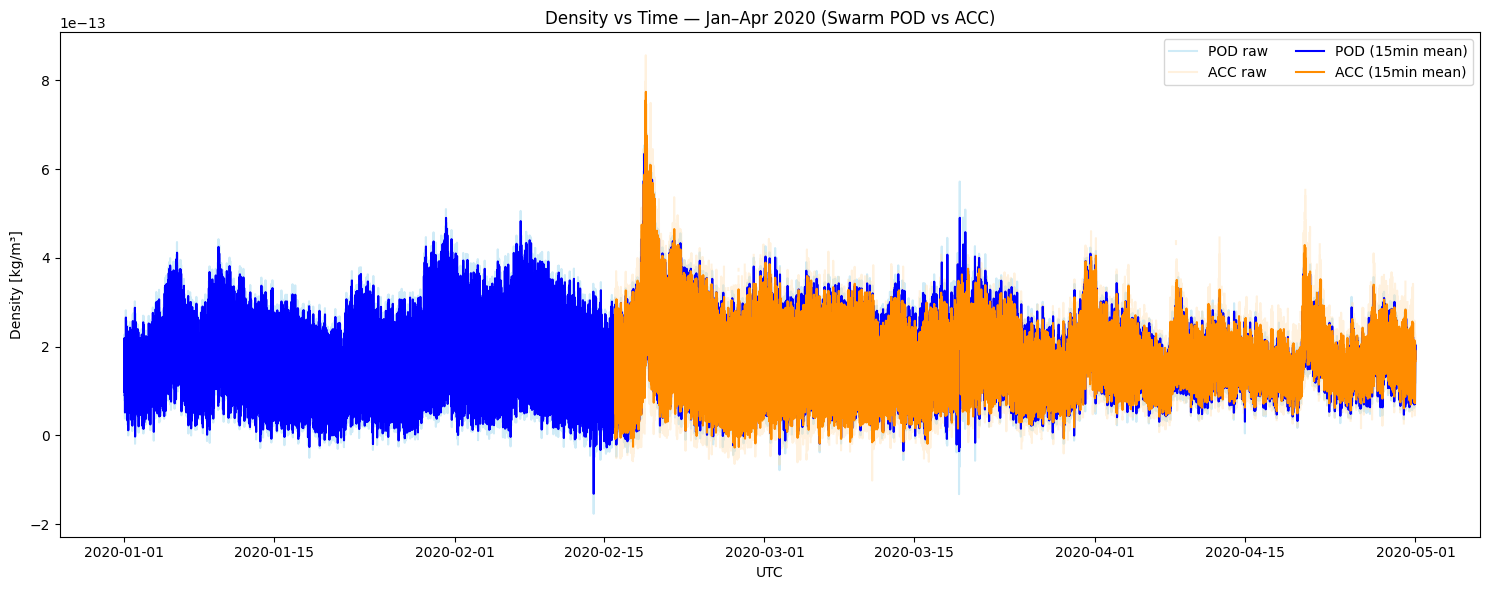

In [31]:
# 保存したDNSを読み込み
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

# DNSを1〜4月分に結合
def concat_dns_jan_to_apr(DNS):
    frames = []
    for k in sorted(DNS.keys()):
        df = DNS[k]["data"]
        if not df.empty:
            df_jan_apr = df.loc["2020-01-01":"2020-04-30 23:59:59"]
            if not df_jan_apr.empty:
                frames.append(df_jan_apr)
    return pd.concat(frames).sort_index() if frames else pd.DataFrame()

P_all = concat_dns_jan_to_apr(DNS_POD).rename(columns={"density":"rho_pod"})
A_all = concat_dns_jan_to_apr(DNS_ACC).rename(columns={"density":"rho_acc"})

# PODを基準にACCを時間合わせ（±30秒）
merged = pd.merge_asof(
    P_all.sort_index()[["rho_pod"]],
    A_all.sort_index()[["rho_acc"]],
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)

# 15分移動平均で平滑化
mv = merged.rolling("15min", min_periods=1).mean()

# === プロット ===
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(merged.index, merged["rho_pod"], color="skyblue", alpha=0.4, label="POD raw")
ax.plot(merged.index, merged["rho_acc"], color="navajowhite", alpha=0.4, label="ACC raw")
ax.plot(mv.index, mv["rho_pod"], color="blue", label="POD (15min mean)")
ax.plot(mv.index, mv["rho_acc"], color="darkorange", label="ACC (15min mean)")

ax.set_title("Density vs Time — Jan–Apr 2020 (Swarm POD vs ACC)")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend(ncol=2)
plt.tight_layout(); plt.show()


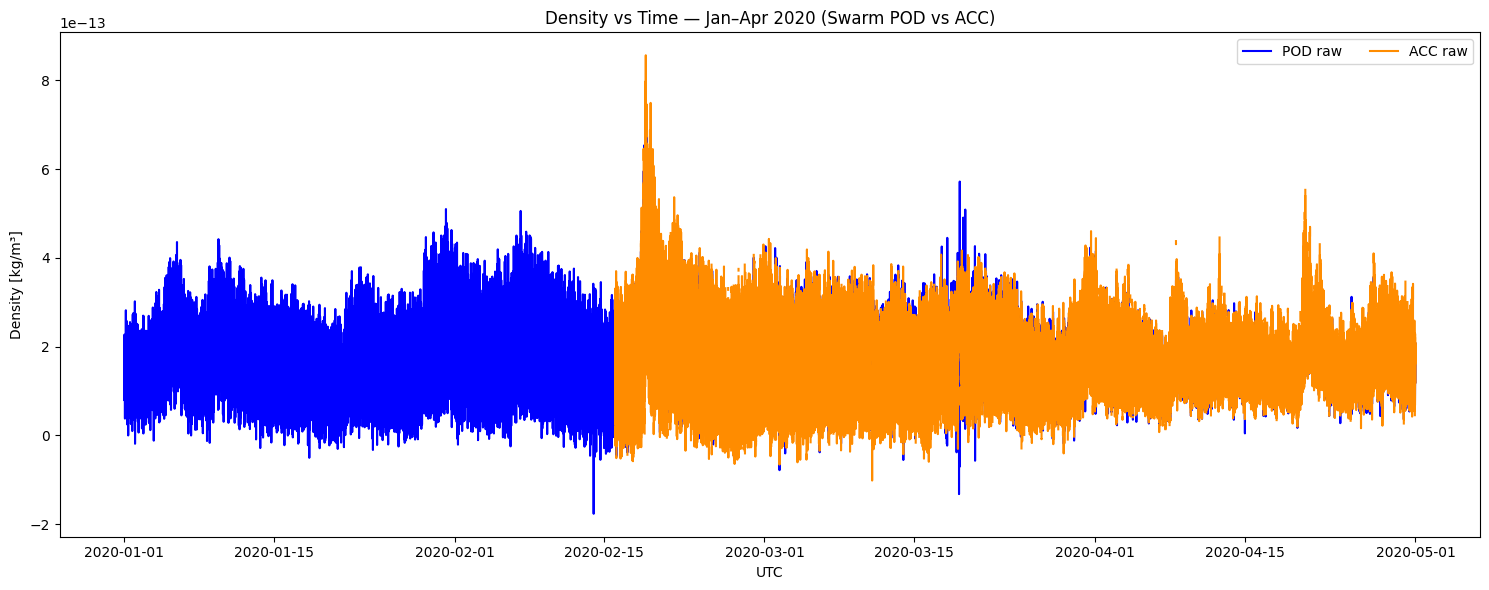

In [37]:
# 保存したDNSを読み込み
DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

# DNSを1〜4月分に結合
def concat_dns_jan_to_apr(DNS):
    frames = []
    for k in sorted(DNS.keys()):
        df = DNS[k]["data"]
        if not df.empty:
            df_jan_apr = df.loc["2020-01-01":"2020-04-30 23:59:59"]
            if not df_jan_apr.empty:
                frames.append(df_jan_apr)
    return pd.concat(frames).sort_index() if frames else pd.DataFrame()

P_all = concat_dns_jan_to_apr(DNS_POD).rename(columns={"density":"rho_pod"})
A_all = concat_dns_jan_to_apr(DNS_ACC).rename(columns={"density":"rho_acc"})

# PODを基準にACCを時間合わせ（±30秒）
merged = pd.merge_asof(
    P_all.sort_index()[["rho_pod"]],
    A_all.sort_index()[["rho_acc"]],
    left_index=True, right_index=True,
    direction="nearest", tolerance=pd.Timedelta("30s")
)


# === プロット ===
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(merged.index, merged["rho_pod"], color="blue", label="POD raw")
ax.plot(merged.index, merged["rho_acc"], color="darkorange", label="ACC raw")

ax.set_title("Density vs Time — Jan–Apr 2020 (Swarm POD vs ACC)")
ax.set_ylabel("Density [kg/m³]")
ax.set_xlabel("UTC")
ax.legend(ncol=2)
plt.tight_layout(); plt.show()

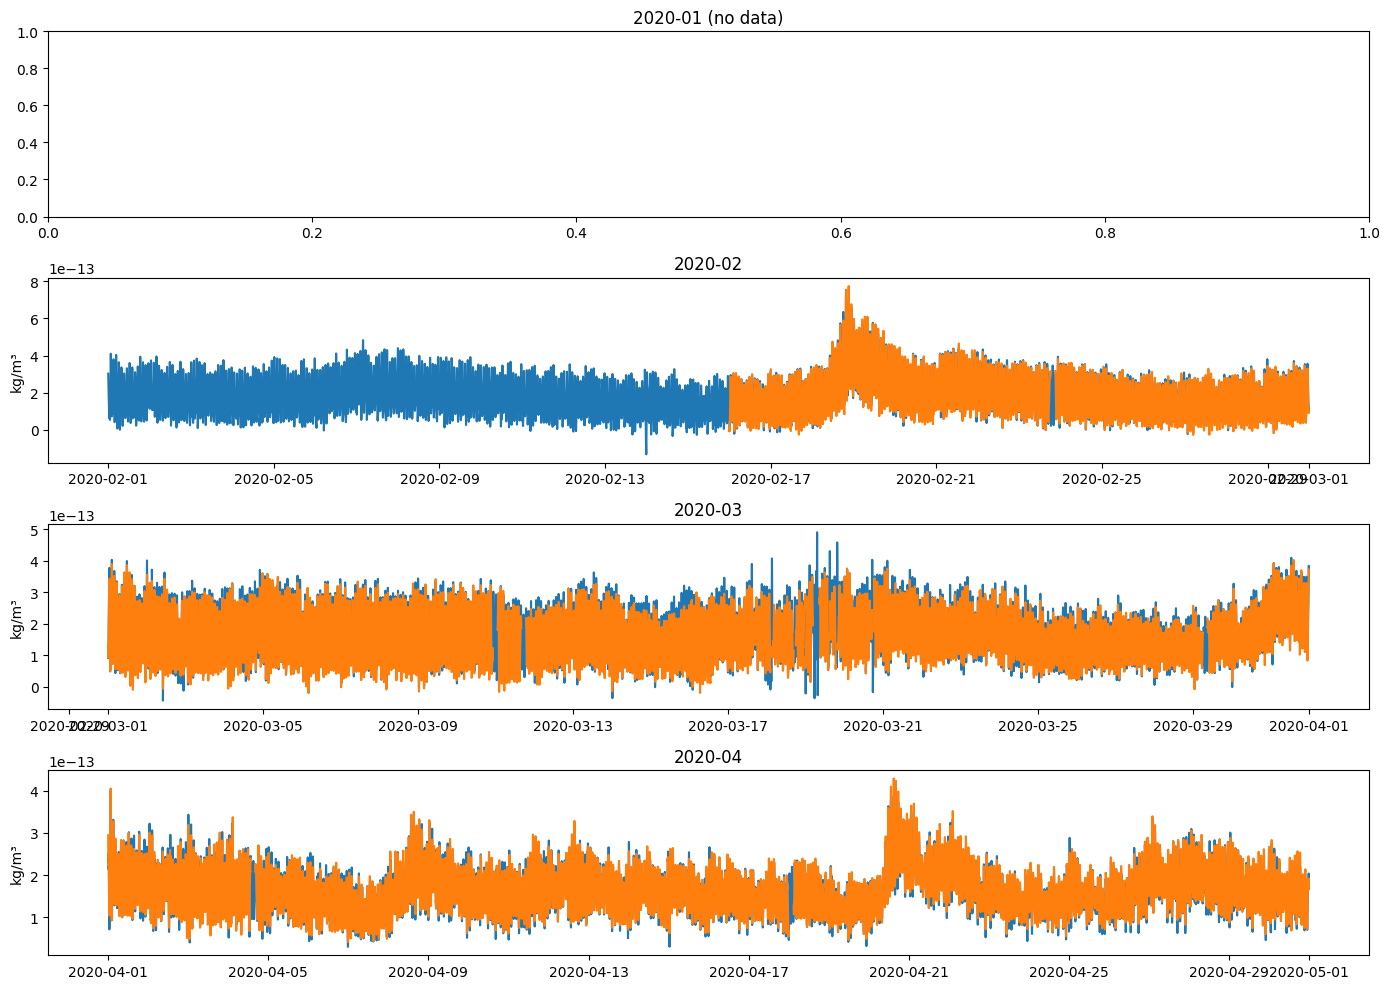

In [ ]:

DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

def concat_dns_month(DNS, y, m):
    start = pd.Timestamp(y, m, 1)
    end   = (start + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    frames=[]
    for k in sorted(DNS.keys()):
        df = DNS[k]["data"]
        if not df.empty:
            cut = df.loc[start:end]
            if not cut.empty: frames.append(cut)
    return pd.concat(frames).sort_index() if frames else pd.DataFrame()

fig, axes = plt.subplots(4, 1, figsize=(14,10), sharex=False)
for i, m in enumerate([1,2,3,4]):
    P = concat_dns_month(DNS_POD, 2020, m).rename(columns={"density":"rho_pod"})
    A = concat_dns_month(DNS_ACC, 2020, m).rename(columns={"density":"rho_acc"})
    if P.empty or A.empty:
        axes[i].set_title(f"2020-{m:02d} (no data)"); continue
    M = pd.merge_asof(P[["rho_pod"]].sort_index(),
                        A[["rho_acc"]].sort_index(),
                        left_index=True, right_index=True,
                        direction="nearest", tolerance=pd.Timedelta("30s"))
    mv = M.rolling("15min", min_periods=1).mean()
    axes[i].plot(mv.index, mv["rho_pod"], label="POD (15min mean)")
    axes[i].plot(mv.index, mv["rho_acc"], label="ACC (15min mean)")
    axes[i].set_ylabel("kg/m³"); axes[i].set_title(f"2020-{m:02d}")
    if i==0: axes[i].legend(ncol=2)
plt.tight_layout(); plt.show()


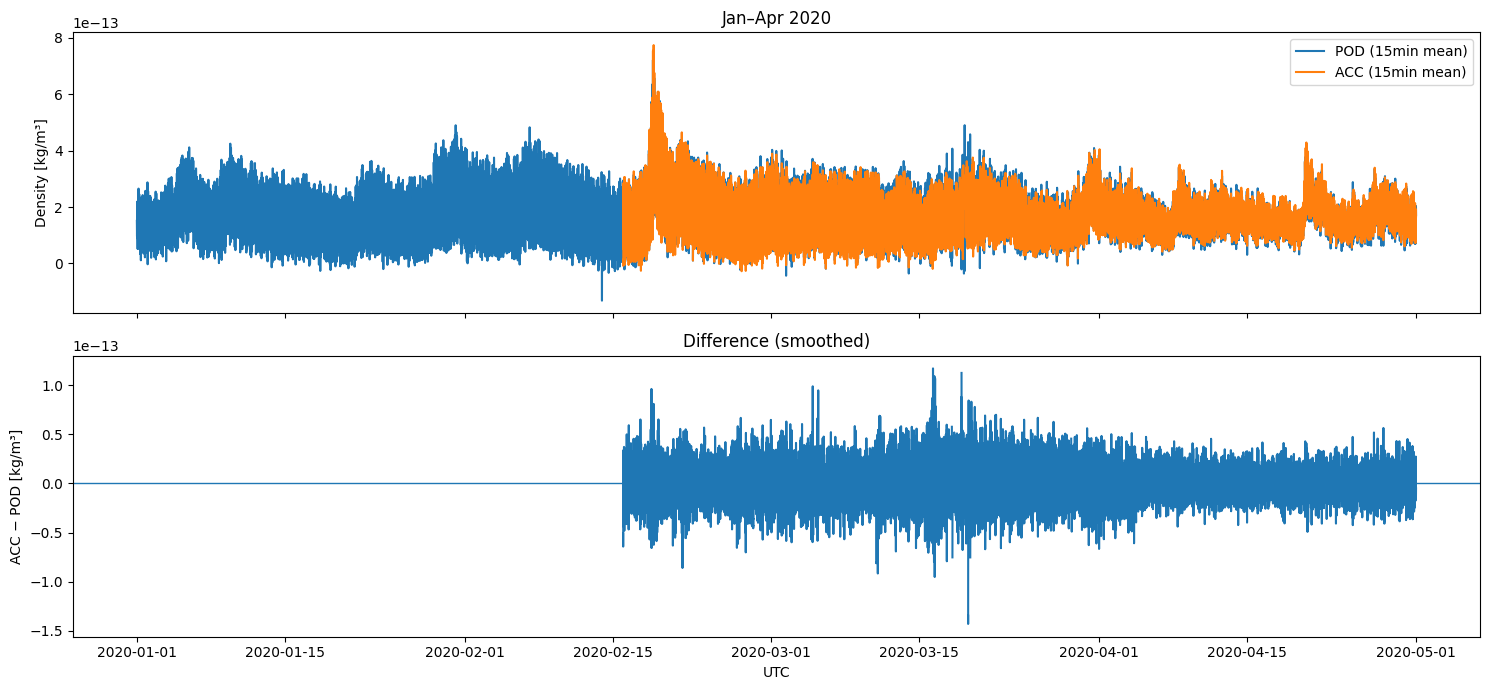

In [30]:


DNS_POD = pickle.load(open("DNS_POD_2020.pkl","rb"))
DNS_ACC = pickle.load(open("DNS_ACC_2020.pkl","rb"))

def concat_dns(DNS):
    frames=[DNS[k]["data"] for k in sorted(DNS.keys()) if not DNS[k]["data"].empty]
    return pd.concat(frames).sort_index()

P = concat_dns(DNS_POD).loc["2020-01-01":"2020-04-30"].rename(columns={"density":"rho_pod"})
A = concat_dns(DNS_ACC).loc["2020-01-01":"2020-04-30"].rename(columns={"density":"rho_acc"})
M = pd.merge_asof(P[["rho_pod"]].sort_index(),
                  A[["rho_acc"]].sort_index(),
                  left_index=True, right_index=True,
                  direction="nearest", tolerance=pd.Timedelta("30s"))
mv = M.rolling("15min", min_periods=1).mean()
diff = mv["rho_acc"] - mv["rho_pod"]     # 差分（必要なら比率: mv["rho_acc"]/mv["rho_pod"]）

fig, axes = plt.subplots(2,1,figsize=(15,7), sharex=True)
axes[0].plot(mv.index, mv["rho_pod"], label="POD (15min mean)")
axes[0].plot(mv.index, mv["rho_acc"], label="ACC (15min mean)")
axes[0].set_ylabel("Density [kg/m³]"); axes[0].set_title("Jan–Apr 2020")
axes[0].legend()

axes[1].plot(diff.index, diff)
axes[1].axhline(0, linewidth=1)
axes[1].set_ylabel("ACC − POD [kg/m³]")
axes[1].set_xlabel("UTC"); axes[1].set_title("Difference (smoothed)")

plt.tight_layout(); plt.show()
